<a href="https://colab.research.google.com/github/shyakx/Air-Quality-Forecasting/blob/main/air_quality_forecasting_starter_code_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Air Quality Forecasting using LSTM

This notebook addresses the problem of forecasting PM2.5 air pollution levels in Beijing using Recurrent Neural Networks (RNNs), specifically LSTM models. By leveraging historical air quality and meteorological data, this project aims to provide accurate predictions that can assist in proactive environmental management.


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - loss: 16126.8203 - val_loss: 20022.6387
Epoch 2/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 13723.5664 - val_loss: 18115.1270
Epoch 3/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 12485.0254 - val_loss: 16575.0352
Epoch 4/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - loss: 11292.9160 - val_loss: 15336.2461
Epoch 5/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - loss: 10259.6445 - val_loss: 14348.5420
Epoch 6/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 9738.8018 - val_loss: 13576.4678
Epoch 7/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 8825.2119 - val_loss: 12981.9229
Epoch 8/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 8434.9941 - val_loss: 12539.1768
Epoch 9/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 8515.9834 - val_loss: 12221.3096
Epoch 10/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - loss: 8232.0498 - val_loss: 11999.6787
Epoch 11/30
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step 

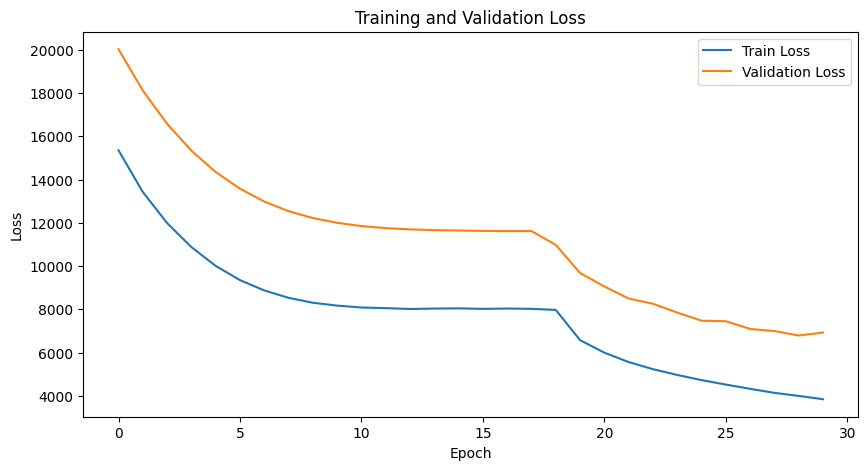

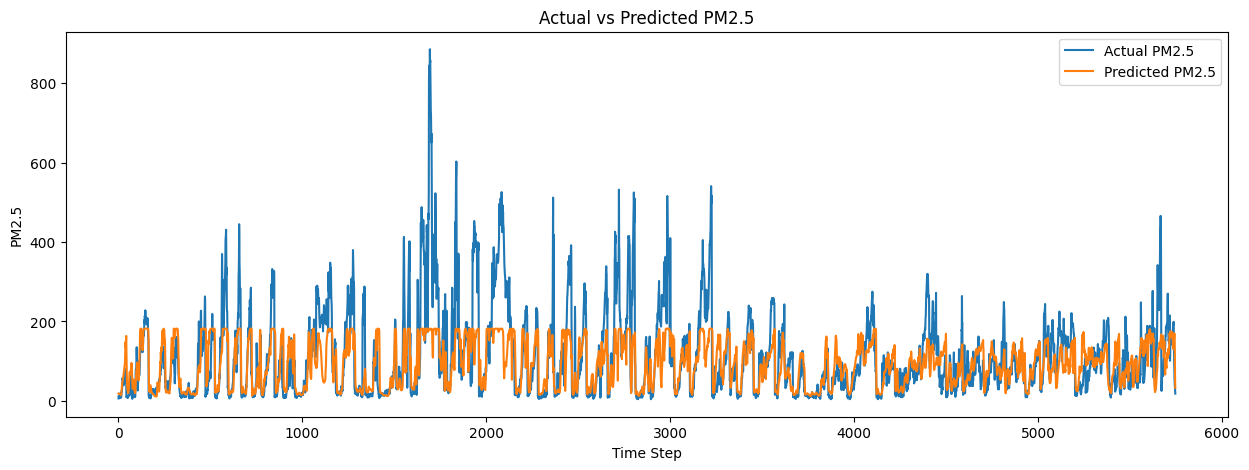

411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Submission file 'submission.csv' saved.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

# Load the dataset
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Rename column for consistency
train_df.rename(columns={'pm2.5': 'PM2_5'}, inplace=True)
test_df.rename(columns={'pm2.5': 'PM2_5'}, inplace=True)

# Drop rows with missing values
train_df.dropna(subset=['PM2_5'], inplace=True)

# Convert datetime
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
train_df.set_index('datetime', inplace=True)

# Normalize the data
features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(train_df[features])

# Create dataset with sequences
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 24
X, y = create_sequences(scaled_features, train_df['PM2_5'].values, sequence_length)

# Train/Validation Split
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stop], verbose=1)

# Evaluate
val_pred = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f"Validation RMSE: {rmse:.2f}")

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot predictions
plt.figure(figsize=(15, 5))
plt.plot(y_val, label='Actual PM2.5')
plt.plot(val_pred, label='Predicted PM2.5')
plt.legend()
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Step')
plt.ylabel('PM2.5')
plt.show()

# Prepare test data
test_df['datetime'] = pd.to_datetime(test_df['datetime'])
test_df.set_index('datetime', inplace=True)
test_features = scaler.transform(test_df[features])

# Create test sequences
X_test = []
for i in range(len(test_features) - sequence_length):
    X_test.append(test_features[i:i + sequence_length])
X_test = np.array(X_test)

# Predict on test data
test_pred = model.predict(X_test)

# Generate timestamps for predictions
prediction_dates = test_df.index[sequence_length:]

# Save submission
submission_df = pd.DataFrame({
    'datetime': prediction_dates,
    'PM2_5': test_pred.flatten()
})
submission_df.to_csv('/content/submission.csv', index=False)

print("Submission file 'submission.csv' has been saved.")